In [1]:
from collections import defaultdict

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from data import classification_dataset, train_test_split
from layers import SeluConv3D, SeluDense
from plot import plot_slice, plot_volume_animation
from config import (
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_BIG_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_BIG_POS_TFRECORD,
    SPIE_SMALL_NEG_TFRECORD,
    SPIE_BIG_NEG_TFRECORD,
    SPIE_SMALL_POS_TFRECORD,
    SPIE_BIG_POS_TFRECORD,
    SMALL_PATCH_SHAPE,
    BIG_PATCH_SHAPE,
    SEED,
)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

In [2]:
lidc_dataset, lidc_samples = classification_dataset(
    LIDC_SMALL_NEG_TFRECORD,
    LIDC_BIG_NEG_TFRECORD,
    LIDC_SMALL_POS_TFRECORD,
    LIDC_BIG_POS_TFRECORD,
    return_size=True,
)
print(f"{lidc_samples = }")
lidc_dataset

lidc_samples = 754


<ShuffleDataset shapes: (((None, None, None, None), (None, None, None, None)), (1,)), types: ((tf.float32, tf.float32), tf.int8)>

In [3]:
# (small, big), label = next(iter(lidc_dataset.skip(100)))
# print(label)
# plot_volume_animation(small)

In [4]:
def build_3d_cnn(dropout_rate=0.0):
    input_small = keras.Input(SMALL_PATCH_SHAPE, name="input_small")
    x_small = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="small_selu_conv3d_1",
    )(input_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_1")(x_small)
    x_small = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="small_selu_conv3d_2",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_2")(x_small)
    x_small = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="small_selu_conv3d_3",
    )(x_small)
    x_small = keras.layers.MaxPooling3D((1, 2, 2), name="small_maxpool_3")(x_small)
    x_small = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="small_selu_conv3d_4",
    )(x_small)
    x_small = keras.layers.Permute((1, 2, 4, 3), name="small_permute_1")(x_small)
    x_small = keras.layers.MaxPooling3D((1, 1, 8), name="small_maxpool_4")(x_small)
    x_small = keras.layers.Permute((1, 2, 4, 3), name="small_permute_2")(x_small)
    x_small = keras.layers.Flatten(name="flatten_small")(x_small)

    input_big = keras.Input(BIG_PATCH_SHAPE, name="input_big")
    x_big = keras.layers.MaxPooling3D((2, 2, 2), name="big_maxpool_0")(input_big)
    x_big = SeluConv3D(
        filters=32,
        kernel_size=3,
        name="big_selu_conv3d_1",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_1")(x_big)
    x_big = SeluConv3D(
        filters=64,
        kernel_size=3,
        name="big_selu_conv3d_2",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_2")(x_big)
    x_big = SeluConv3D(
        filters=128,
        kernel_size=3,
        name="big_selu_conv3d_3",
    )(x_big)
    x_big = keras.layers.MaxPooling3D((1, 2, 2), name="big_maxpool_3")(x_big)
    x_big = SeluConv3D(
        filters=256,
        kernel_size=3,
        name="big_selu_conv3d_4",
    )(x_big)
    x_big = keras.layers.Permute((1, 2, 4, 3), name="big_permute_1")(x_big)
    x_big = keras.layers.MaxPooling3D((1, 1, 8), name="big_maxpool_4")(x_big)
    x_big = keras.layers.Permute((1, 2, 4, 3), name="big_permute_2")(x_big)
    x_big = keras.layers.Flatten(name="flatten_big")(x_big)

    x = keras.layers.concatenate([x_small, x_big], name="concatenate")
    x = SeluDense(256, name="selu_dense")(x)
    x = keras.layers.AlphaDropout(dropout_rate)(x)
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(x)

    cnn_3d = keras.Model(inputs=[input_small, input_big], outputs=x, name="3dcnn")

    return cnn_3d

In [5]:
val_perc = 0.1
batch_size = 16

In [ ]:
lidc_train_dataset, lidc_val_dataset = train_test_split(
    lidc_dataset, test_perc=val_perc
)
lidc_val_dataset = lidc_val_dataset.batch(batch_size)
lidc_train_dataset = (
    lidc_train_dataset.cache()  # must be called before shuffle
    .shuffle(buffer_size=lidc_samples, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
lidc_train_dataset

In [ ]:
patience = 30
learning_rate = 1e-5
dropout_rate = 0.0

In [ ]:
cnn = build_3d_cnn(dropout_rate)
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

cnn.fit(
    lidc_train_dataset,
    validation_data=lidc_val_dataset,
    epochs=1000,
    verbose=0,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "models/lidc-3d-cnn.h5",
            monitor="val_loss",
            save_best_only=True,
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
        ),
        keras.callbacks.TensorBoard(
            log_dir="logs/lidc-3d-cnn",
            histogram_freq=1,
            write_graph=False,
            profile_batch=0,
        ),
    ],
)

In [ ]:
cnn.evaluate(lidc_val_dataset, return_dict=True)

In [6]:
spie_dataset, spie_samples = classification_dataset(
    SPIE_SMALL_NEG_TFRECORD,
    SPIE_BIG_NEG_TFRECORD,
    SPIE_SMALL_POS_TFRECORD,
    SPIE_BIG_POS_TFRECORD,
    return_size=True,
)
print(f"{spie_samples = }")
spie_dataset

spie_samples = 73


<ShuffleDataset shapes: (((None, None, None, None), (None, None, None, None)), (1,)), types: ((tf.float32, tf.float32), tf.int8)>

In [7]:
def build_pretrained_3d_cnn():
    pretrained_3d_cnn = keras.models.load_model("models/lidc-3d-cnn.h5")
    pretrained_3d_cnn.trainable = False
    x = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(
        pretrained_3d_cnn.layers[-3].output
    )
    return keras.Model(inputs=pretrained_3d_cnn.input, outputs=x)

In [8]:
rounds = 10
fracs = (1, 2, 3, 4, 5)
test_perc = 0.25
batch_size = 8
learning_rate = 1e-5
wo_pretraining_num_epochs = 1000
wo_pretraining_patience = 30
w_pretraining_num_epochs = 10_000
w_pretraining_patience = 5_000
dropout_rate = 0.6
dataset = spie_dataset
metrics = [
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
]

In [ ]:
data = defaultdict(list)
for r in tqdm(range(rounds)):
    full_train_dataset, test_dataset = train_test_split(
        dataset, test_perc=test_perc, seed=None
    )
    test_dataset = test_dataset.batch(batch_size)
    for frac in fracs:
        val_dataset, train_dataset = train_test_split(
            full_train_dataset, test_perc=(1 / frac), seed=None
        )
        val_dataset = val_dataset.batch(batch_size)
        if sum(1 for _ in val_dataset) == 0:
            val_dataset = test_dataset
        train_dataset = (
            train_dataset.cache()  # must be called before shuffle
            .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

        cnn = build_3d_cnn(dropout_rate)
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.MeanSquaredError(),
            metrics=metrics,
        )
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=wo_pretraining_patience,
                restore_best_weights=True,
            )
        ]
        if r < 2:  # first two rounds log the training
            callbacks.append(
                keras.callbacks.TensorBoard(
                    log_dir=f"logs/{r}-3d-cnn-wo-pretraining-{frac}",
                    histogram_freq=2,
                    write_graph=False,
                    profile_batch=0,
                )
            )
        cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=wo_pretraining_num_epochs,
            verbose=0,
            callbacks=callbacks,
        )
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("3D CNN W/O pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("3D CNN W/O pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

        cnn = build_pretrained_3d_cnn()
        cnn.compile(
            optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.MeanSquaredError(),
            metrics=metrics,
        )
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=w_pretraining_patience,
                restore_best_weights=True,
            )
        ]
        if r < 2:  # first two rounds log the training
            callbacks.append(
                keras.callbacks.TensorBoard(
                    log_dir=f"logs/{r}-3d-cnn-w-pretraining-{frac}",
                    histogram_freq=2,
                    write_graph=False,
                    profile_batch=0,
                )
            )
        cnn.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=w_pretraining_num_epochs,
            verbose=0,
            callbacks=callbacks,
        )
        test_metrics = cnn.evaluate(test_dataset, return_dict=True, verbose=False)
        data["nn_type"].append("3D CNN W/ pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("AUC")
        data["metric_value"].append(test_metrics["auc"])
        data["nn_type"].append("3D CNN W/ pretraining")
        data["train_size_fraction"].append(frac)
        data["metric"].append("Accuracy")
        data["metric_value"].append(test_metrics["accuracy"])

df = pd.DataFrame(data)
df.to_csv("frac-training.csv", index=False)

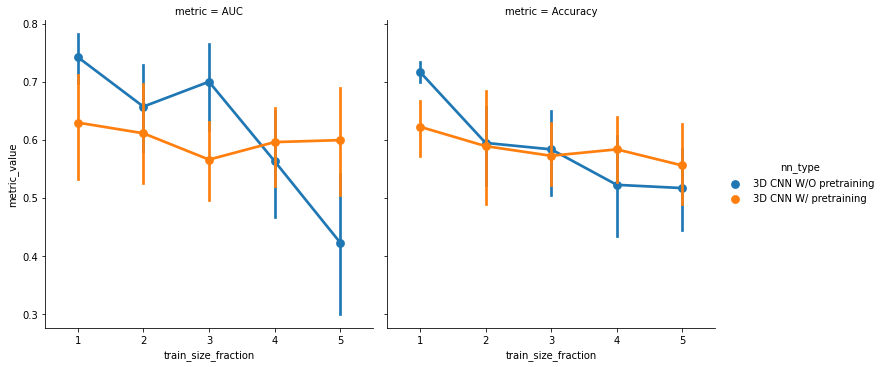

In [2]:
df = pd.read_csv("frac-training.csv")
sns.catplot(
    x="train_size_fraction",
    y="metric_value",
    hue="nn_type",
    col="metric",
    kind="point",
    data=df,
)